In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter

C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# Define the URLs for the datasets of the variables we want to download (temperature, geopotential height, humidity, v-wind, u-wind)
urls = {
    'temperature_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022400_2019022423.nc',
    'geopotential_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019022400_2019022423.nc',
    'mslp_sfc': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc',    
    'humidity_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019022400_2019022423.nc',
    'v_wind_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019022400_2019022423.nc',
    'u_wind_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019022400_2019022423.nc',
    'u_wind_sfc': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc',
    'v_wind_sfc': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc'
}

# Load the datasets from the URLs
datasets = {}
for var, url in urls.items():
    tds_catalog = TDSCatalog(url)
    ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
    ds = xr.open_dataset(ds_url).metpy.parse_cf()
    datasets[var] = ds

# Merge all pressure level datasets into a single Xarray Dataset
ds_pl = xr.merge([datasets['temperature_pl'], datasets['geopotential_pl'], datasets['humidity_pl'], datasets['v_wind_pl'], datasets['u_wind_pl']])

# Merge all surface datasets into a single Xarray Dataset
ds_sfc = xr.merge([datasets['mslp_sfc'], datasets['v_wind_sfc'], datasets['u_wind_sfc']])

C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022400_2019022423.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022400_2019022423.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,
C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019022400_2019022423.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g

In [9]:
def plot_ivt(g, ds, directions):
    # Loop over the reanlysis time steps
    for i in range(0, len(ds.time)):
        # Slice the dataset to get the data for the current time step
        ds_sliced = ds.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_sliced = ds_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        
        # Slice the dataset to get the data for the pressure levels between 500 and 1000 hPa
        u_sliced = ds_sliced['U'].sel(level=slice(500, 1000)) # units: m/s
        v_sliced = ds_sliced['V'].sel(level=slice(500, 1000)) # units: m/s
        q_sliced = ds_sliced['Q'].sel(level=slice(500, 1000)) # units: kg/kg

        # Flip the order of the pressure levels and convert them to Pa from hPa
        pressure_levels = u_sliced.level[::-1] * 100 # units: Pa

        # Calculate the integrated vapor transport (IVT) using the u- and v-wind components and the specific humidity
        u_ivt = -1 / g * np.trapz(u_sliced * q_sliced, pressure_levels, axis=0)
        v_ivt = -1 / g * np.trapz(v_sliced * q_sliced, pressure_levels, axis=0)

        # Calculate the IVT magnitude
        ivt = np.sqrt(u_ivt**2 + v_ivt**2)

        # Create an xarray DataArray for the IVT
        ivt_da = xr.DataArray(ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        # Define the color levels and colors for the IVT plot
        levels = [250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1600, 1800]
        colors = ['#ffff00', '#ffe400', '#ffc800', '#ffad00', '#ff8200', '#ff5000', '#ff1e00', '#eb0010', '#b8003a', '#850063', '#570088']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Create the figure
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the IVT
        c = plt.contour(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), colors='black', levels=levels, linewidths=0.5)
        cf = plt.contourf(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), cmap=cmap, levels=levels, norm=norm, extend='max')
        plt.colorbar(cf, orientation='vertical', label='IVT (kg/m/s)', fraction=0.046, pad=0.04)

        # Mask the IVT values below 250 kg/m/s and create a filtered DataArray for the u- and v-wind components
        mask = ivt_da >= 250
        u_ivt_filtered = xr.DataArray(u_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)
        v_ivt_filtered = xr.DataArray(v_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)

        # Plot the IVT vectors
        step = 5 
        plt.quiver(u_ivt_filtered['longitude'][::step], u_ivt_filtered['latitude'][::step], u_ivt_filtered[::step, ::step], v_ivt_filtered[::step, ::step], scale=500,scale_units='xy', color='black')
        
        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis Integrated Water Vapor Transport (IVT) | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-1])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='#ecf9fd')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        plt.tight_layout()
        #plt.savefig(f'IVT_{i}.png', dpi=450)
        plt.show()

def plot_iwv(g, ds, directions):
    # Loop over the reanalysis time steps
    for i in range(0, len(ds.time)):
        # Slice the dataset to get the data for the current time step
        ds_sliced = ds.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_sliced = ds_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        
        # Slice the dataset to get the data for the pressure levels between 500 and 1000 hPa, or specifically at 850 hPa
        u_sliced = ds_sliced['U'].sel(level=slice(500, 1000)) # units: m/s
        u_850 = ds_sliced['U'].sel(level=850) * 1.94384 # units: knots
        v_sliced = ds_sliced['V'].sel(level=slice(500, 1000)) # units: m/s
        v_850 = ds_sliced['V'].sel(level=850) * 1.94384 # units: knots
        q_sliced = ds_sliced['Q'].sel(level=slice(500, 1000)) # units: kg/kg
        z_sliced = ds_sliced['Z'].sel(level=850) / 100 # units: dam
        pressure_levels = u_sliced.level[::-1] * 100 # units: Pa

        # Calculate the integrated water vapor (IWV) using the specific humidity and put it in an xarray DataArray
        iwv = -1 / g * np.trapz(q_sliced, pressure_levels, axis=0)
        iwv_da = xr.DataArray(iwv, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        # Define the color levels and colors for the IWV plot
        levels = np.arange(20, 61, 2)
        colors = ['#1a2dd3', '#1a43ff', '#2486ff', '#31ccff', '#3cfbf0', '#37e5aa', '#32ce63', '#33be21', '#76d31c', '#bae814', '#fffc02',
                    '#ffe100', '#fec600', '#fdab00', '#fc7800', '#fc4100', '#fc0000','#d2002f', '#a31060', '#711e8b', '#8a51af']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Create the plot 
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the geopotential heights and IWV
        isohypses = plt.contour(z_sliced['longitude'], z_sliced['latitude'], gaussian_filter(z_sliced, sigma=1), colors='black')
        ax.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        c = plt.contour(iwv_da['longitude'], iwv_da['latitude'], gaussian_filter(iwv_da, sigma=1), colors='black', levels=levels, linewidths=0.5)
        cf = plt.contourf(iwv_da['longitude'], iwv_da['latitude'], gaussian_filter(iwv_da, sigma=1), cmap=cmap, levels=levels, norm=norm, extend='max')
        plt.colorbar(cf, orientation='vertical', label='IWV (mm)', fraction=0.046, pad=0.04)

        # Plot the wind barbs for the u- and v-wind components at 850 hPa
        step = 5 
        ax.barbs(u_850['longitude'][::step], u_850['latitude'][::step], u_850[::step, ::step], v_850[::step, ::step], length=6, color='black')
        
        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis Integrated Water Vapor (IWV) | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-1])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='#ecf9fd')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        plt.tight_layout()
        #plt.savefig(f'IVT_{i}.png', dpi=450)
        plt.show()

def plot_250_isotachs(ds, directions):
    # Loop over the reanalysis time steps
    for i in range(20, 23):
        # Slice the dataset to get the data for the current time step
        ds_sliced = ds.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_sliced = ds_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        
        # Slice the dataset to get the data for the pressure level at 250 hPa
        u_250 = ds_sliced['U'].sel(level=250) * 1.94384 # units: knots
        v_250 = ds_sliced['V'].sel(level=250) * 1.94384 # units: knots
        z_250 = ds_sliced['Z'].sel(level=250) # units: m
        pressure_levels = u_250.level* 100 # units: Pa

        # Calculate the wind speed at 250 hPa
        wind_speed_250 = np.sqrt(u_250**2 + v_250**2)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Create the plot 
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the geopotential heights and IWV
        c = plt.contour(z_250['longitude'], z_250['latitude'], gaussian_filter(z_250, sigma=1), colors='black')
        ax.clabel(c, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        c = plt.contour(u_250['longitude'], u_250['latitude'], gaussian_filter(wind_speed_250, sigma=1), colors='black', levels=np.arange(75, 251, 25), linewidths=0.5)
        cf = plt.contourf(u_250['longitude'], u_250['latitude'], gaussian_filter(wind_speed_250, sigma=1), cmap=plt.cm.BuPu, levels=np.arange(75, 251, 25), extend='max')
        plt.colorbar(cf, orientation='vertical', label='Wind Speed (Knots)', fraction=0.046, pad=0.04)

        # Plot the wind barbs for the u- and v-wind components at 250 hPa
        step = 5 
        ax.barbs(u_250['longitude'][::step], u_250['latitude'][::step], u_250[::step, ::step], v_250[::step, ::step], length=6, color='black')

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis 250-hPa Isoatachs, Geopotential Heights, and Wind Barbs | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-1])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='#ecf9fd')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        plt.tight_layout()
        #plt.savefig(f'IVT_{i}.png', dpi=450)
        plt.show()

def plot_500_vorticity(ds, directions):
    # Loop over the reanalysis time steps
    for i in range(20, 23):
        # Slice the dataset to get the data for the current time step
        ds_sliced = ds.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_sliced = ds_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        
        # Slice the dataset to get the data for the pressure level at 500 hPa
        u_500 = ds_sliced['U'].sel(level=500) # units: m/s
        v_500 = ds_sliced['V'].sel(level=500) # units: m/s
        z_500 = ds_sliced['Z'].sel(level=500) # units: m
        pressure_levels = u_500.level* 100 # units: Pa

        # Calculate the wind speed at 500 hPa
        wind_speed_250 = np.sqrt(u_500**2 + v_500**2)

        # Calculate the absolute vorticity at 500 hPa
        absolute_vorticity = mpcalc.absolute_vorticity(u_500, v_500)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Create the plot 
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the geopotential heights and IWV
        c = plt.contour(z_500['longitude'], z_500['latitude'], gaussian_filter(z_500, sigma=1), colors='black')
        ax.clabel(c, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        #c = plt.contour(absolute_vorticity['longitude'], absolute_vorticity['latitude'], gaussian_filter(absolute_vorticity*1e5, sigma=1), colors='black', levels=np.arange(-6, 60, 1), linewidths=0.5)
        cf = plt.contourf(absolute_vorticity['longitude'], absolute_vorticity['latitude'], gaussian_filter(absolute_vorticity*1e5, sigma=1), cmap=plt.cm.PuOr, levels=np.arange(-60, 61, 2), extend='max')
        plt.colorbar(cf, orientation='vertical', label='Vorticity (s^-1)', fraction=0.046, pad=0.04)

        # Plot the wind barbs for the u- and v-wind components at 500 hPa
        step = 5 
        ax.barbs(u_500['longitude'][::step], u_500['latitude'][::step], u_500[::step, ::step], v_500[::step, ::step], length=6, color='black')

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis 500-hPa Absolute Vorticity, Geopotential Heights, and Wind Barbs | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-1])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='#ecf9fd')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        plt.tight_layout()
        #plt.savefig(f'IVT_{i}.png', dpi=450)
        plt.show()

def plot_500_isotachs(ds, directions):
    # Loop over the reanalysis time steps
    for i in range(20, 23):
        # Slice the dataset to get the data for the current time step
        ds_sliced = ds.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_sliced = ds_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        
        # Slice the dataset to get the data for the pressure level at 500 hPa
        temp_500 = ds_sliced['T'].sel(level=500) - 273.15 # units: deg C
        u_500 = ds_sliced['U'].sel(level=500) * 1.94384  # units: knots
        v_500 = ds_sliced['V'].sel(level=500) * 1.94384  # units: knots
        z_500 = ds_sliced['Z'].sel(level=500) # units: m
        pressure_levels = u_500.level* 100 # units: Pa
    
        # Calculate the wind speed at 500 hPa 
        wind_speed_500 = np.sqrt(u_500**2 + v_500**2) 

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Create the plot 
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the stuff
        isotherms = plt.contour(temp_500['longitude'], temp_500['latitude'], gaussian_filter(temp_500, sigma=1), colors='red', levels=np.arange(-40, 10, 5), linestyle='dashed', linewidths=1)
        plt.clabel(isotherms, inline='True', fontsize=12, fmt="%i")
        isohypses = plt.contour(z_500['longitude'], z_500['latitude'], gaussian_filter(z_500 / 100, sigma=1), colors='black')
        ax.clabel(isohypses, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        cf = plt.contourf(u_500['longitude'], u_500['latitude'], gaussian_filter(wind_speed_500, sigma=1), cmap=plt.cm.BuPu, levels=np.arange(20, 161, 20), extend='max')
        plt.colorbar(cf, orientation='vertical', label='Wind Speed (knots)', fraction=0.046, pad=0.04)

        # Plot the wind barbs for the u- and v-wind components at 500 hPa
        step = 5 
        ax.barbs(u_500['longitude'][::step], u_500['latitude'][::step], u_500[::step, ::step], v_500[::step, ::step], length=6, color='black')

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis 500-hPa Isotachs, Geopotential Heights, Temperature, and Wind Barbs | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-1])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='#ecf9fd')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        plt.tight_layout()
        #plt.savefig(f'IVT_{i}.png', dpi=450)
        plt.show()

def plot_250_isotachs_mslp(ds_pl, ds_sfc, directions):
    # Loop over the reanalysis time steps
    for i in range(0, len(ds_pl.time)):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        ds_sfc_sliced = ds_sfc.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        
        # Slice the dataset to get the data for the pressure level at 250 hPa
        u_250 = ds_pl_sliced['U'].sel(level=250) * 1.94384 # units: knots
        v_250 = ds_pl_sliced['V'].sel(level=250) * 1.94384 # units: knots
        z_250 = ds_pl_sliced['Z'].sel(level=250) # units: m
        pressure_levels = u_250.level* 100 # units: Pa

        # Slice the dataset to get the mslp
        mslp = ds_sfc_sliced['MSL'] / 100 # units: hPa

        # Calculate the wind speed at 250 hPa
        wind_speed_250 = np.sqrt(u_250**2 + v_250**2)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Create the plot 
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the geopotential heights and IWV
        #c = plt.contour(z_250['longitude'], z_250['latitude'], gaussian_filter(z_250, sigma=1), colors='black')
        #ax.clabel(c, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        c = plt.contour(mslp['longitude'], mslp['latitude'], gaussian_filter(mslp, sigma=1), colors='black', levels=np.arange(960, 1040, 4), linewidths=0.5)
        #ax.clabel(c, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        c = plt.contour(u_250['longitude'], u_250['latitude'], gaussian_filter(wind_speed_250, sigma=1), colors='black', levels=np.arange(75, 251, 25), linewidths=0.5)
        cf = plt.contourf(u_250['longitude'], u_250['latitude'], gaussian_filter(wind_speed_250, sigma=1), cmap=plt.cm.BuPu, levels=np.arange(75, 251, 25), extend='max')
        plt.colorbar(cf, orientation='vertical', label='Wind Speed (Knots)', fraction=0.046, pad=0.04)

        # Plot the wind barbs for the u- and v-wind components at 250 hPa
        #step = 5 
        #ax.barbs(u_250['longitude'][::step], u_250['latitude'][::step], u_250[::step, ::step], v_250[::step, ::step], length=6, color='black')

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis 250-hPa Isoatachs, Geopotential Heights, and Wind Barbs | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-1])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='#ecf9fd')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        plt.tight_layout()
        #plt.savefig(f'IVT_{i}.png', dpi=450)
        plt.show()

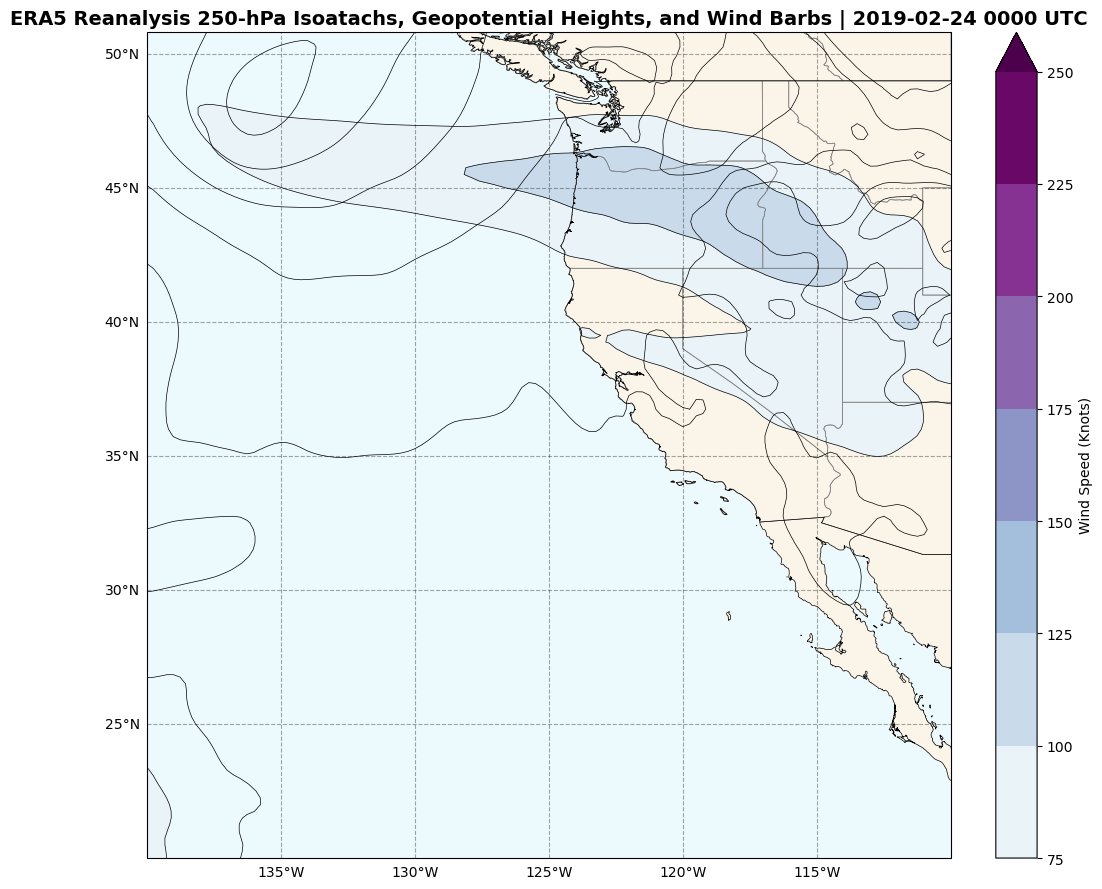

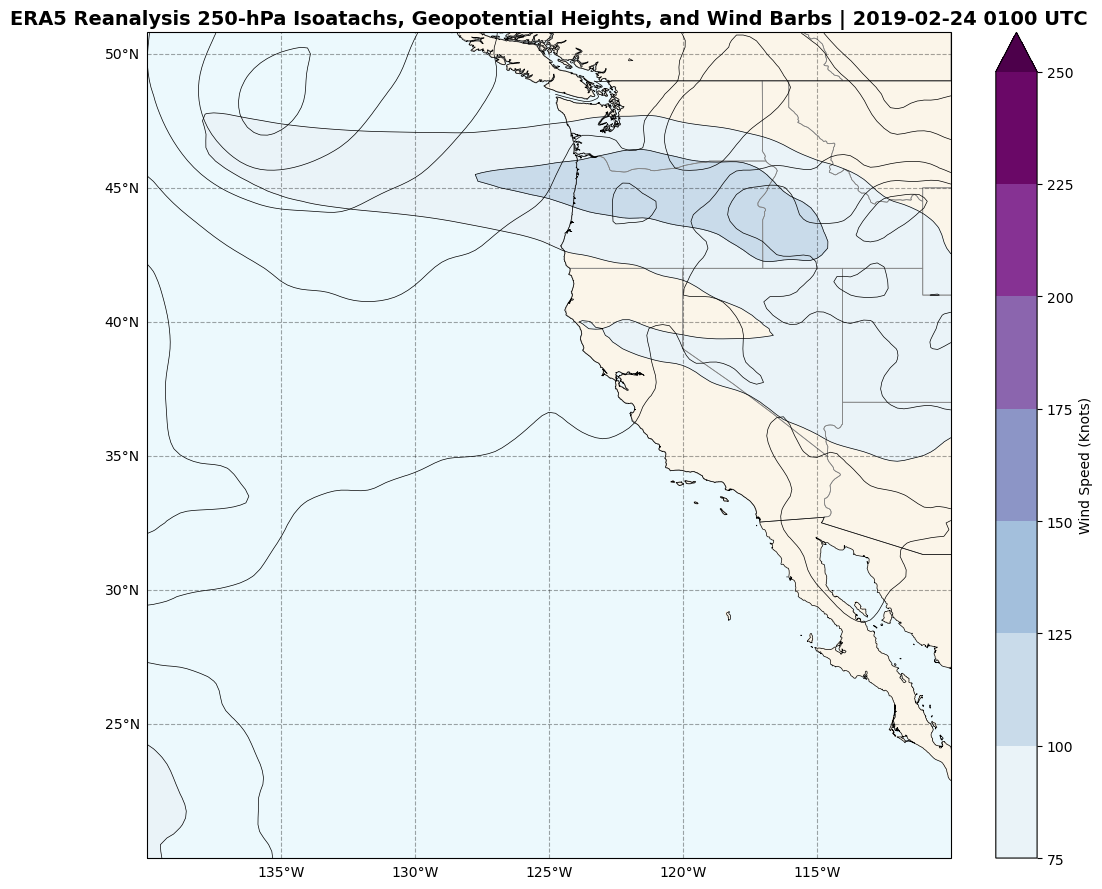

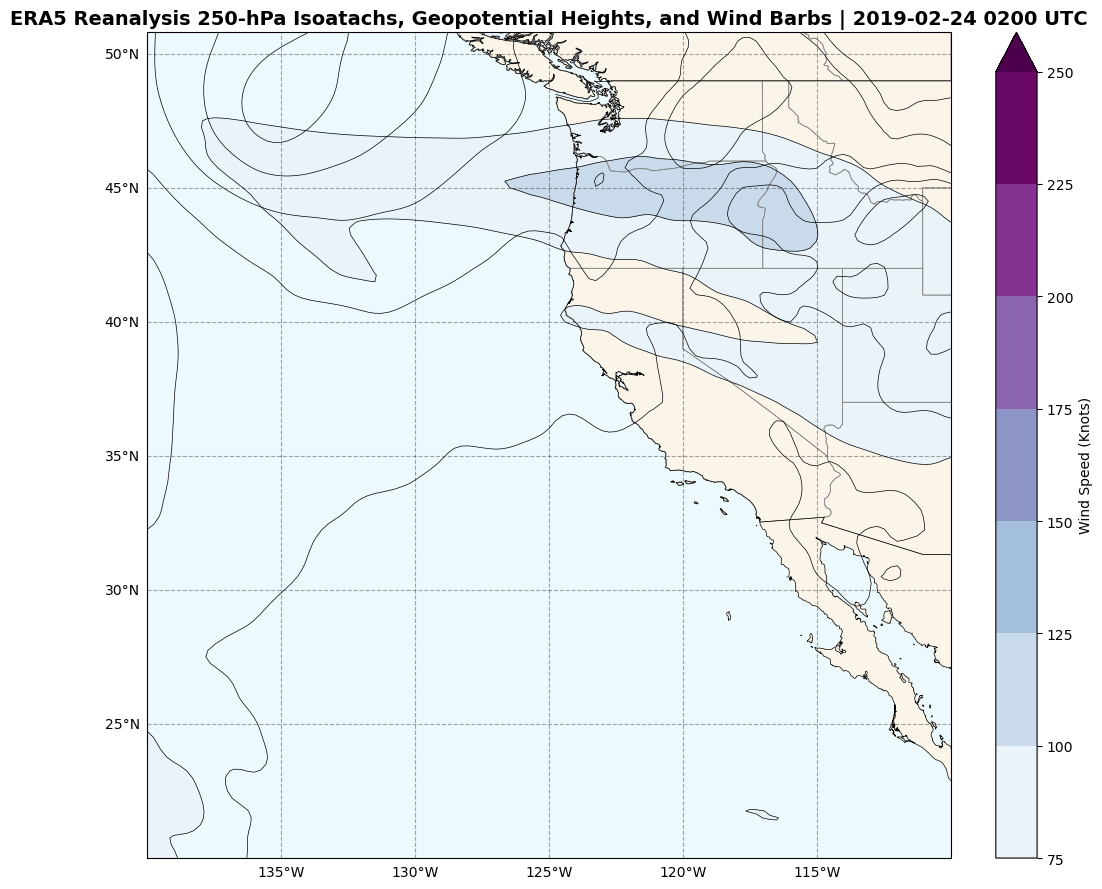

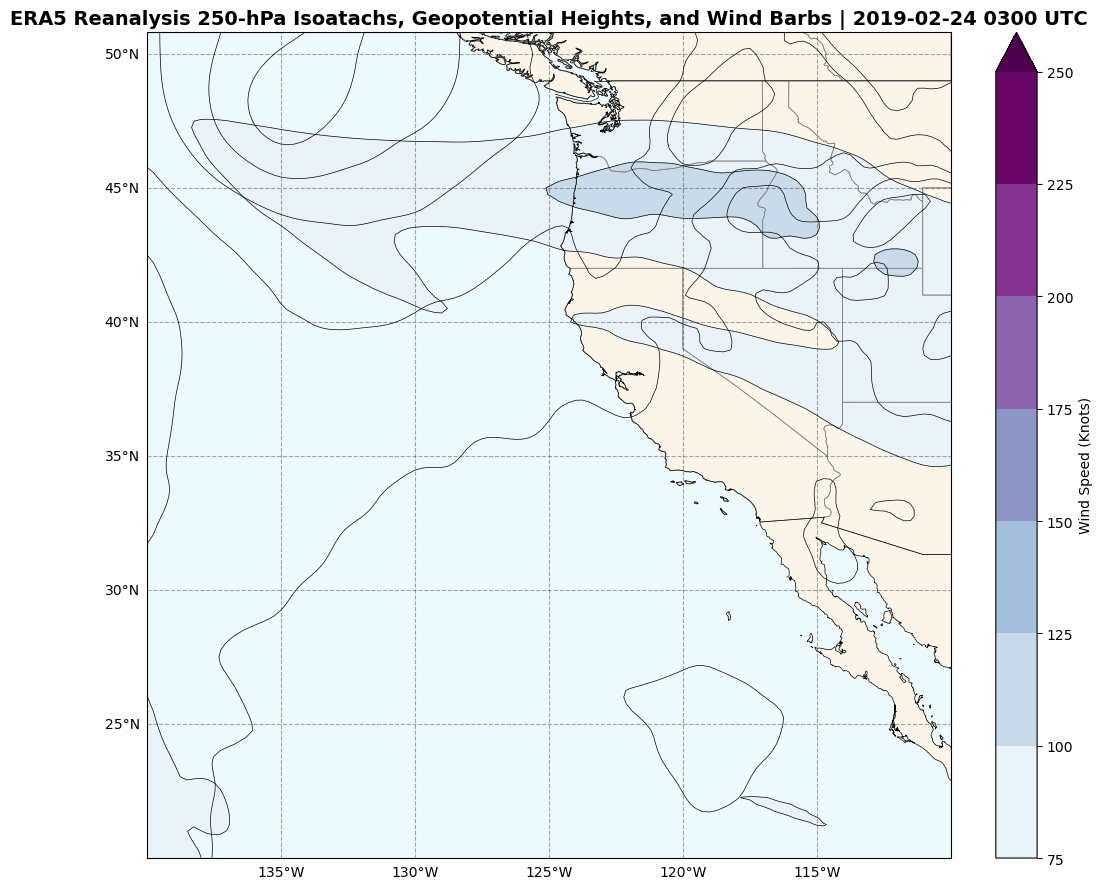

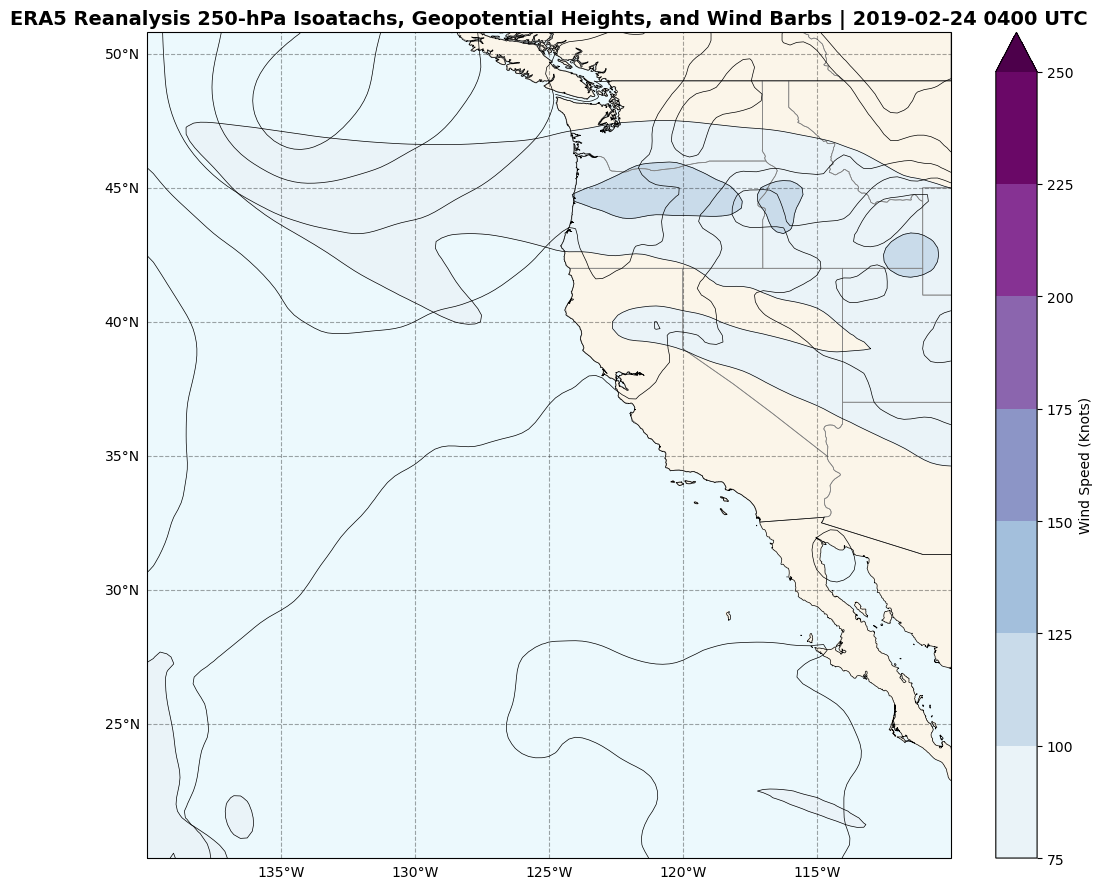

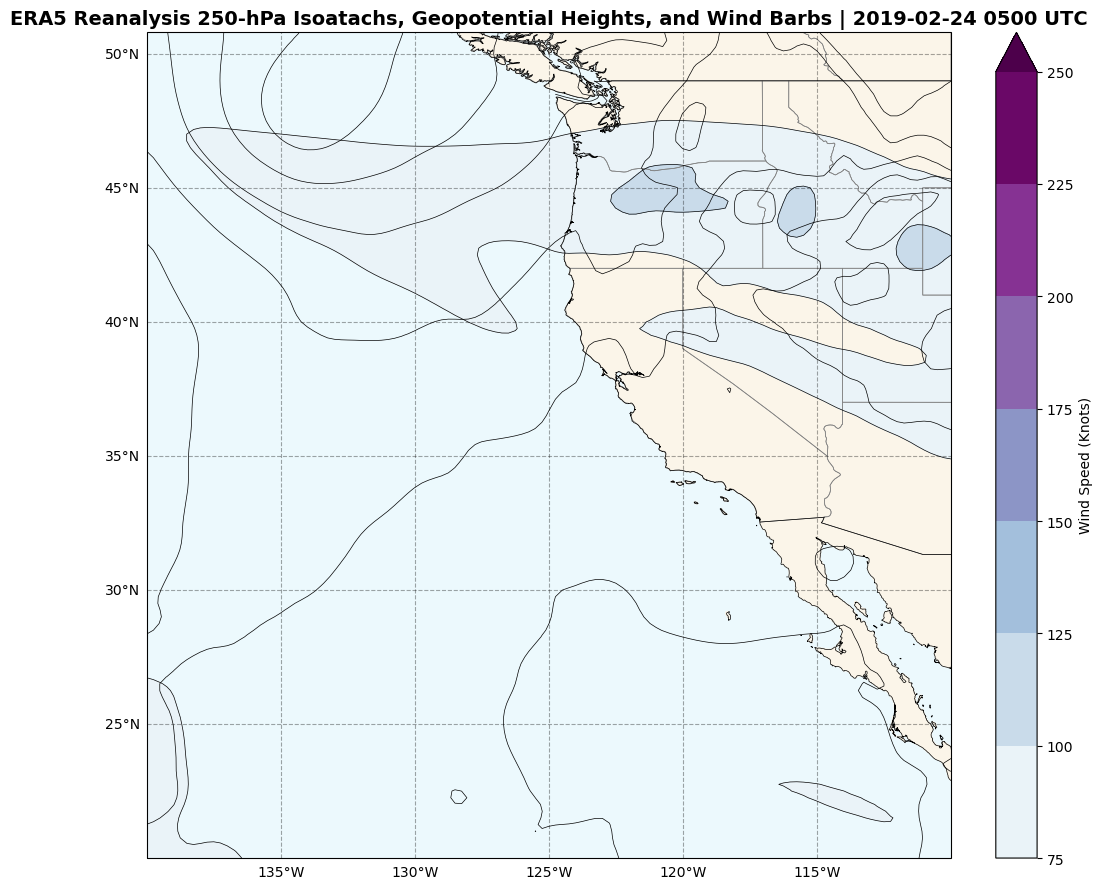

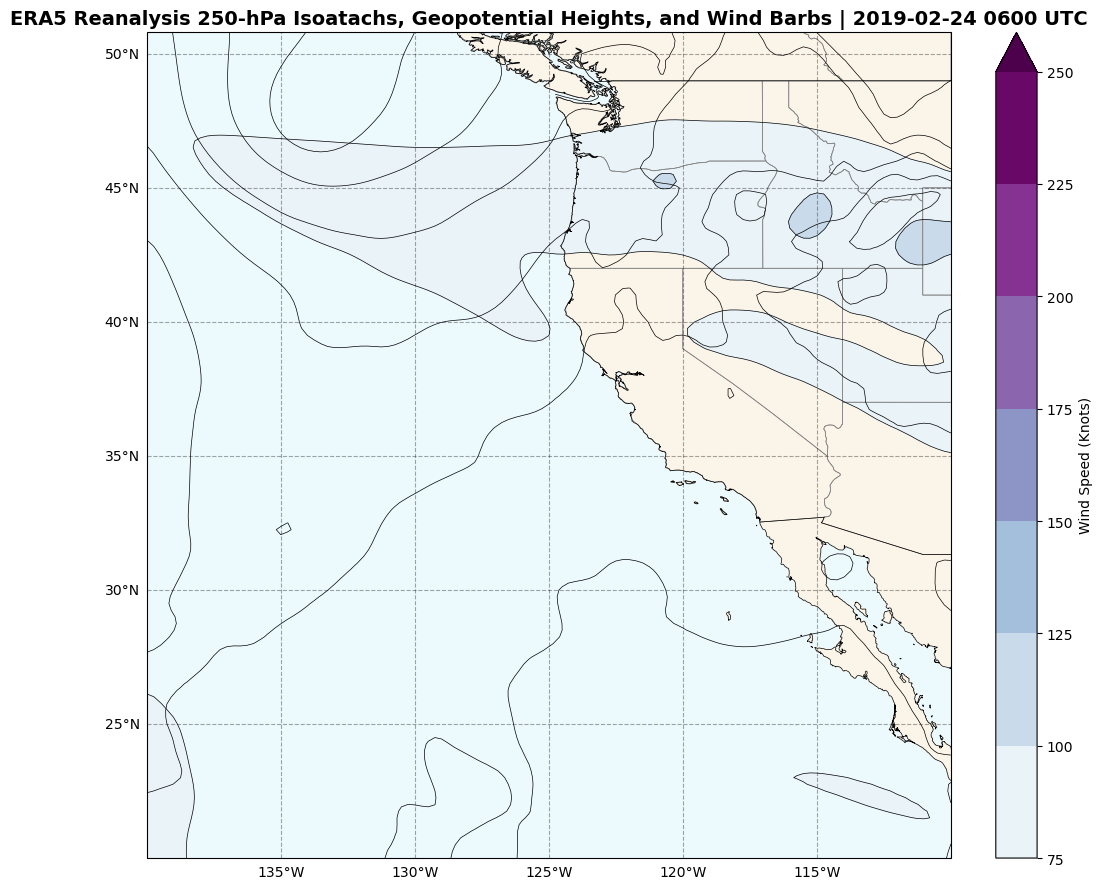

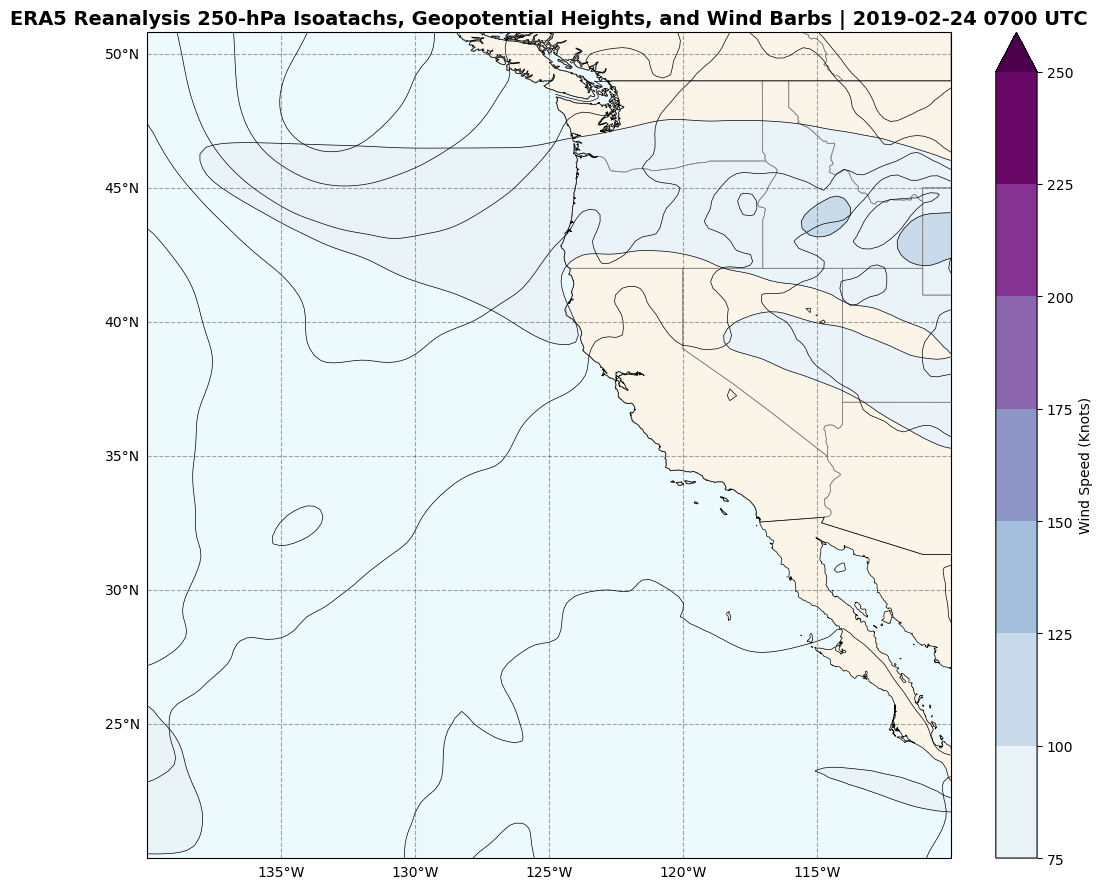

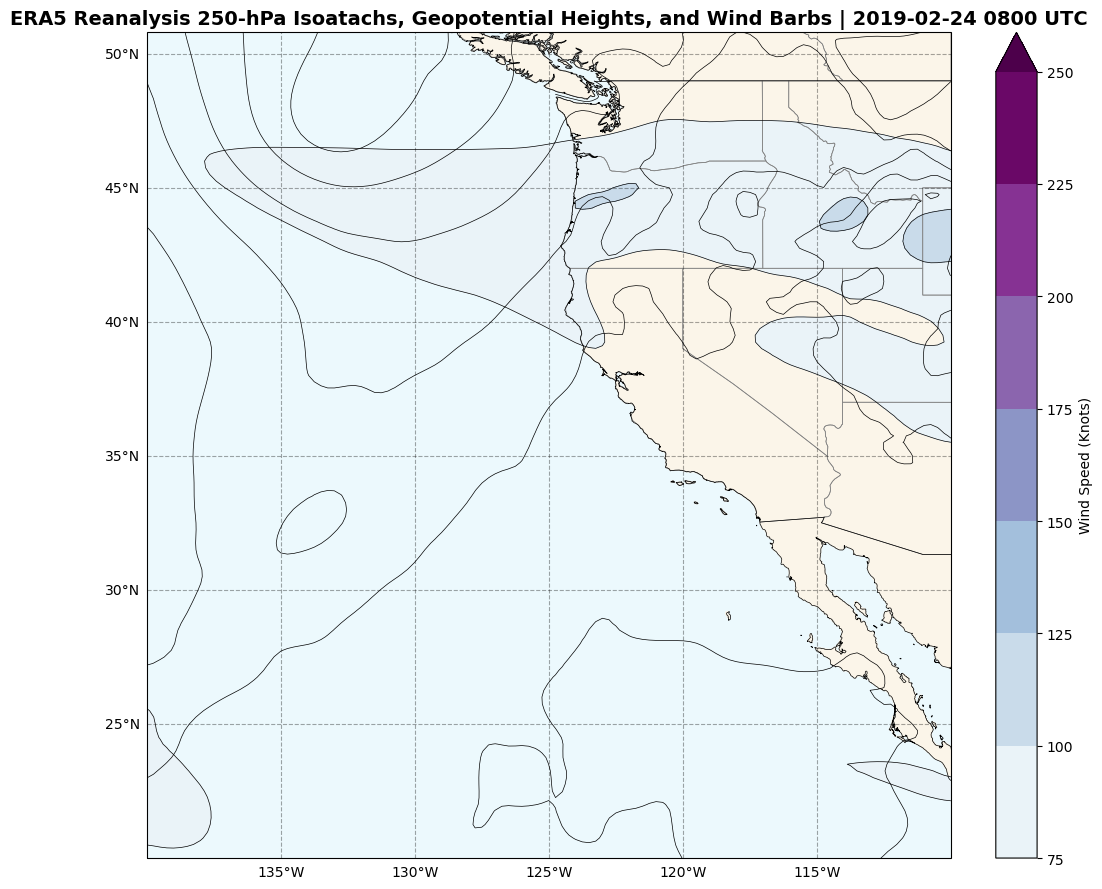

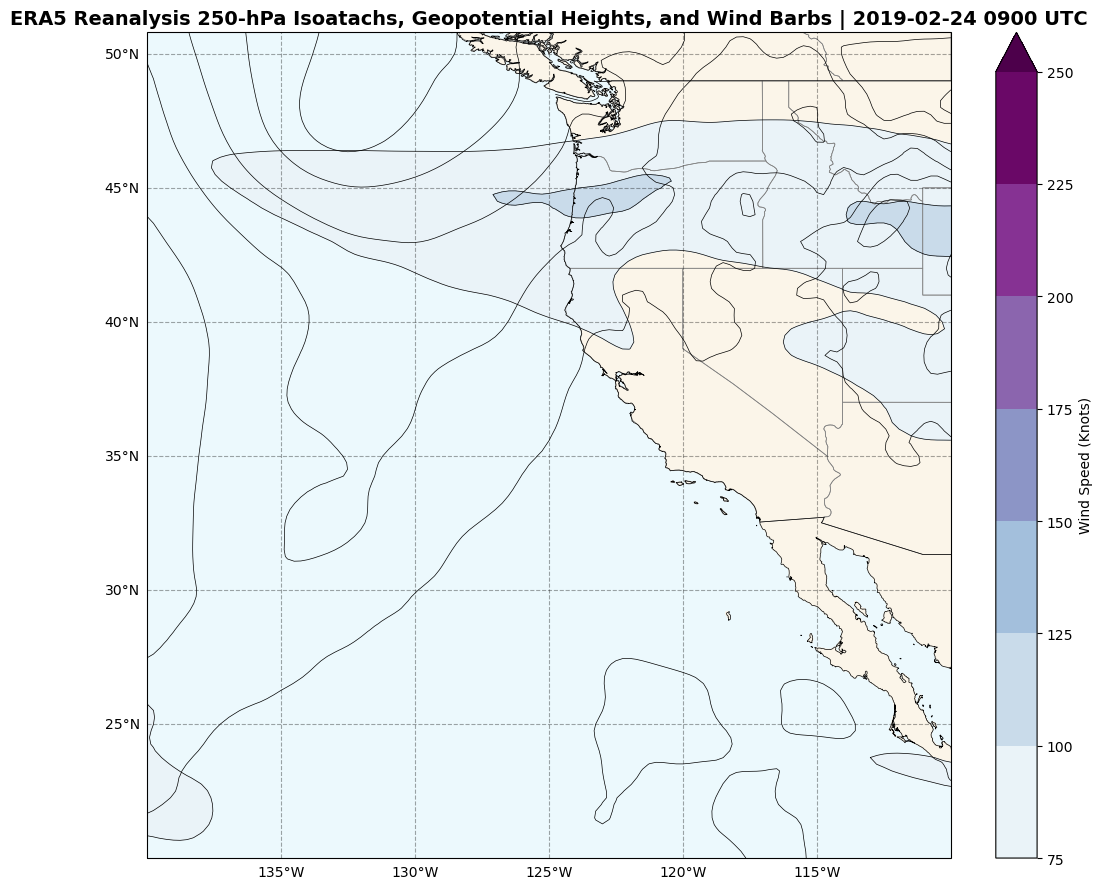

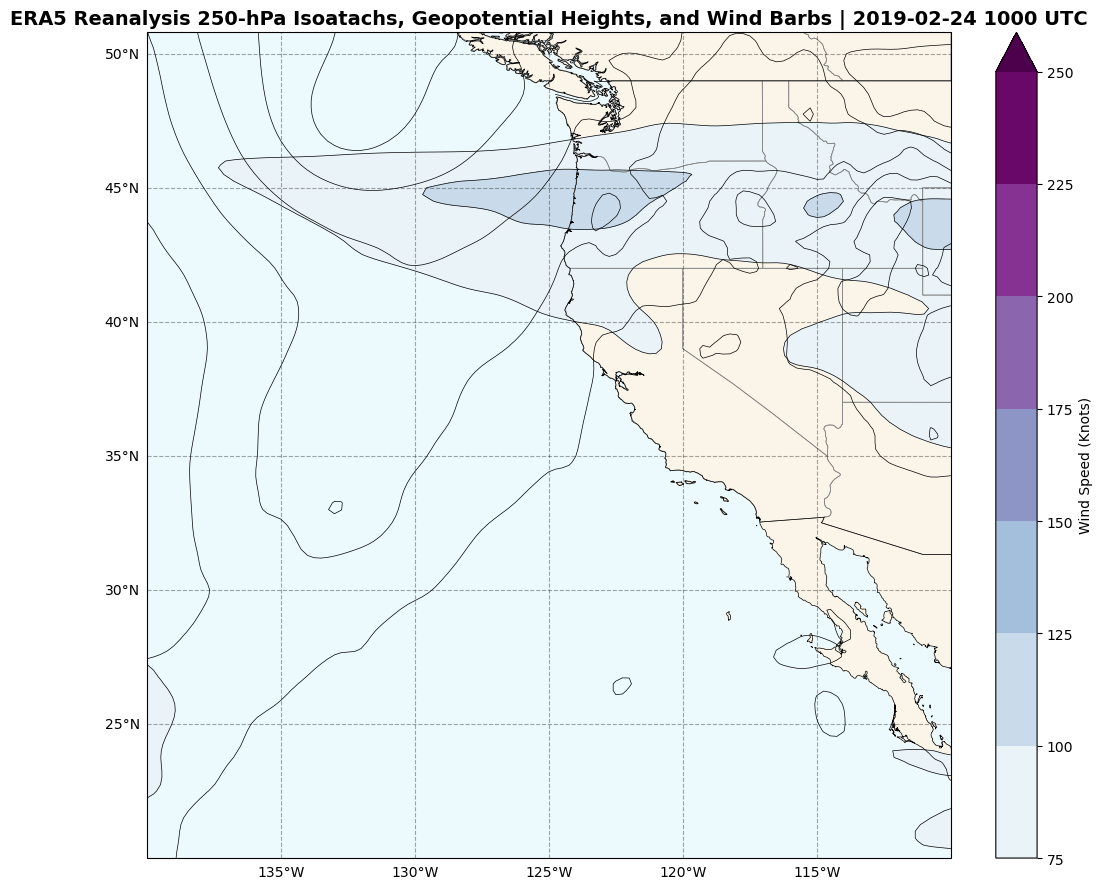

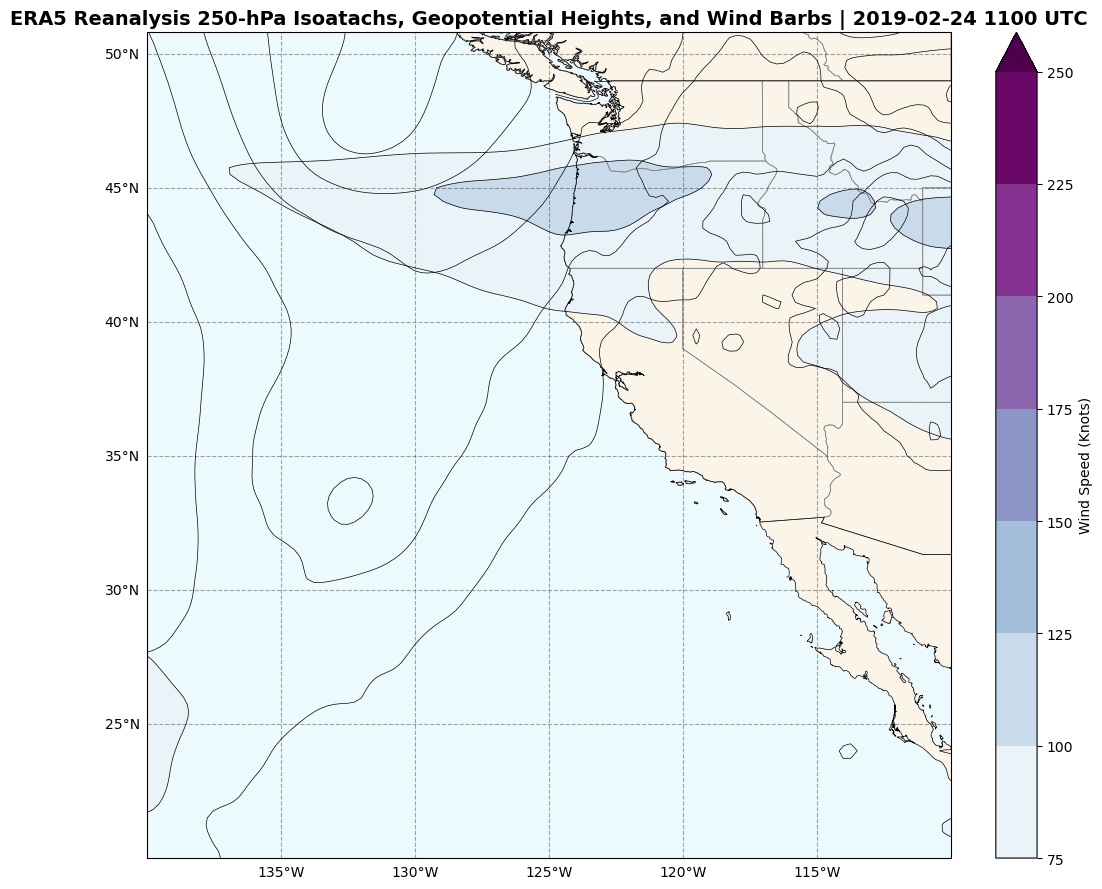

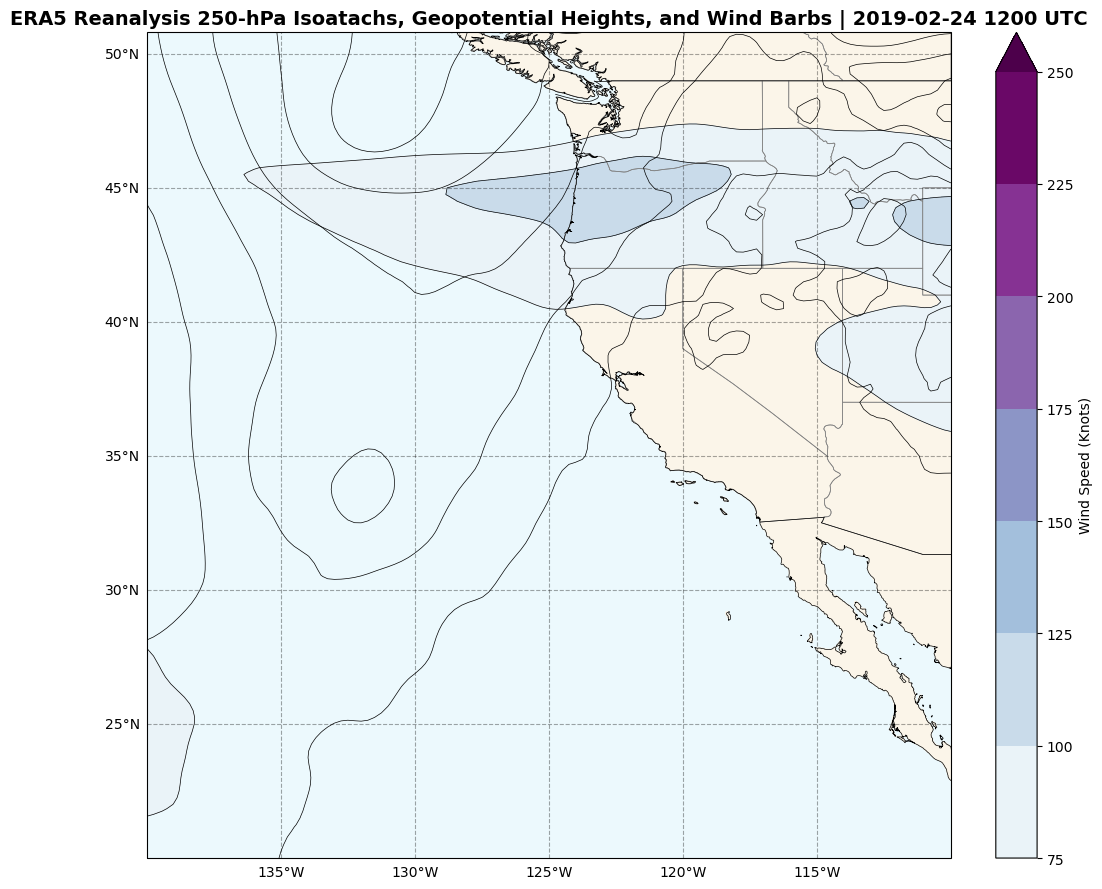

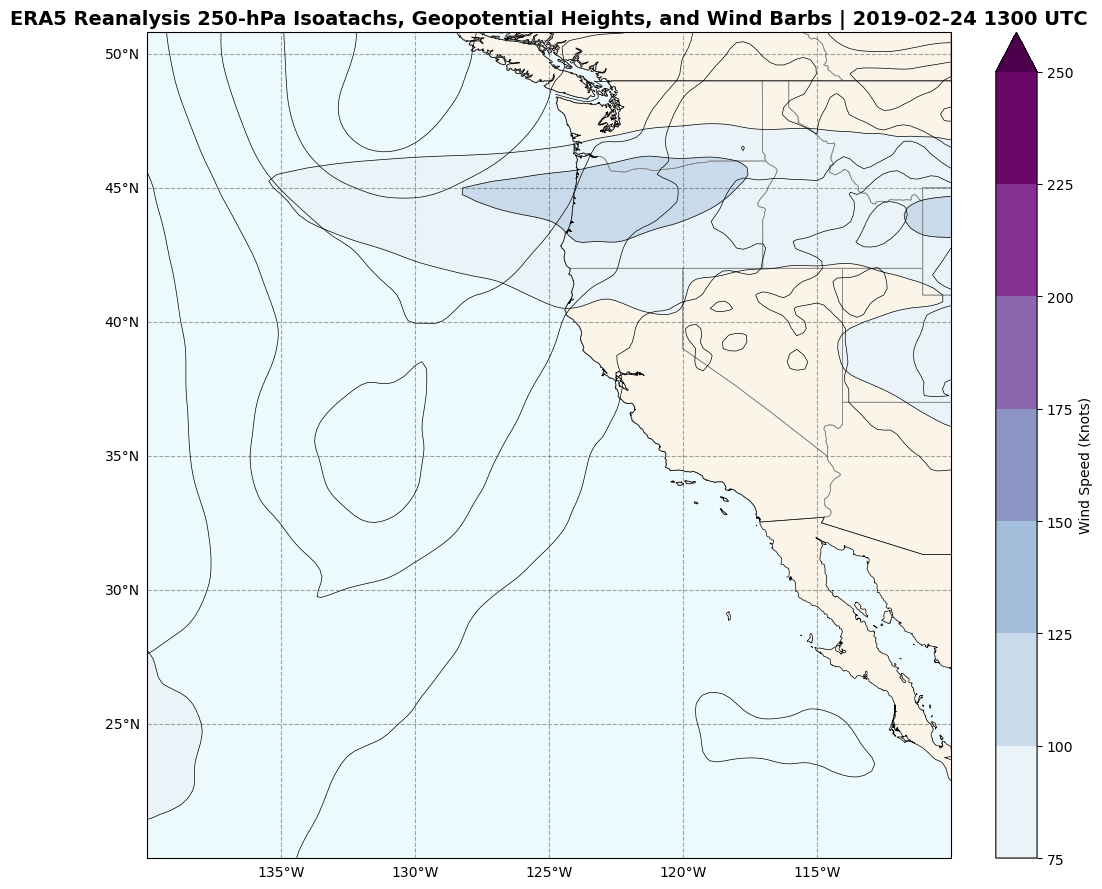

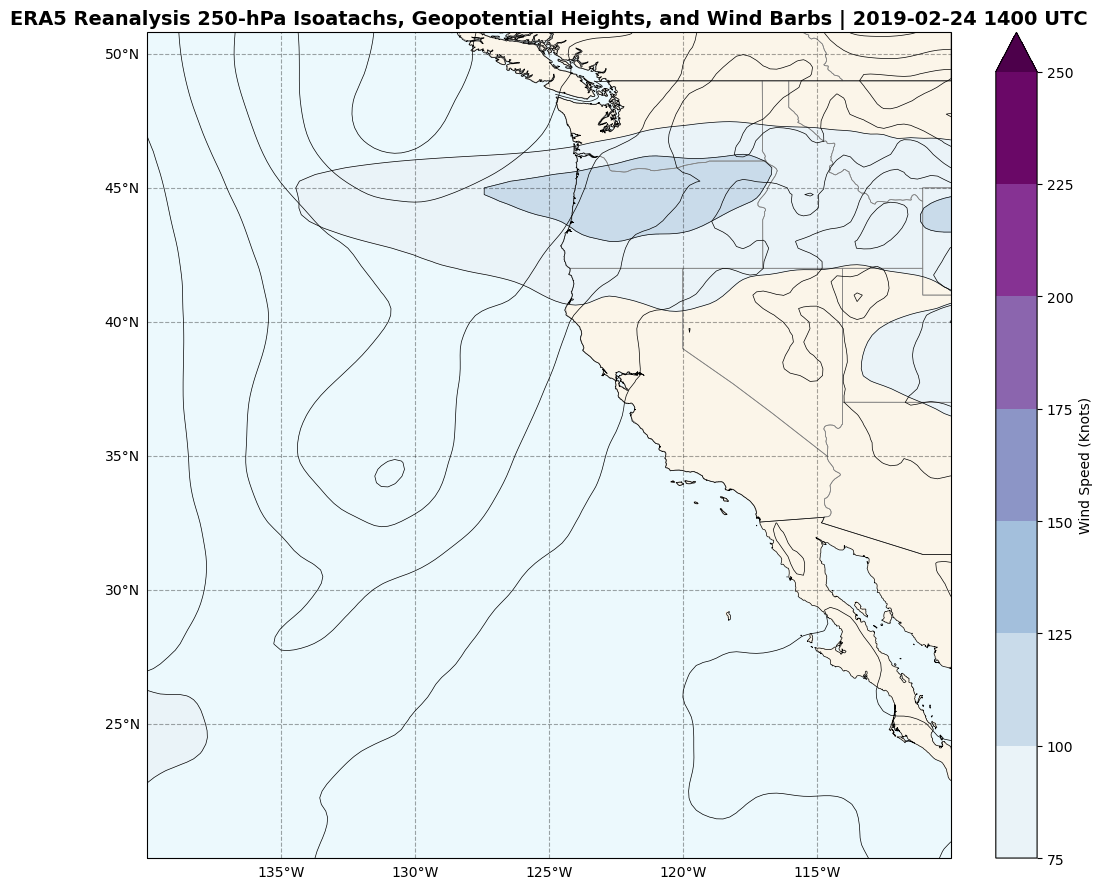

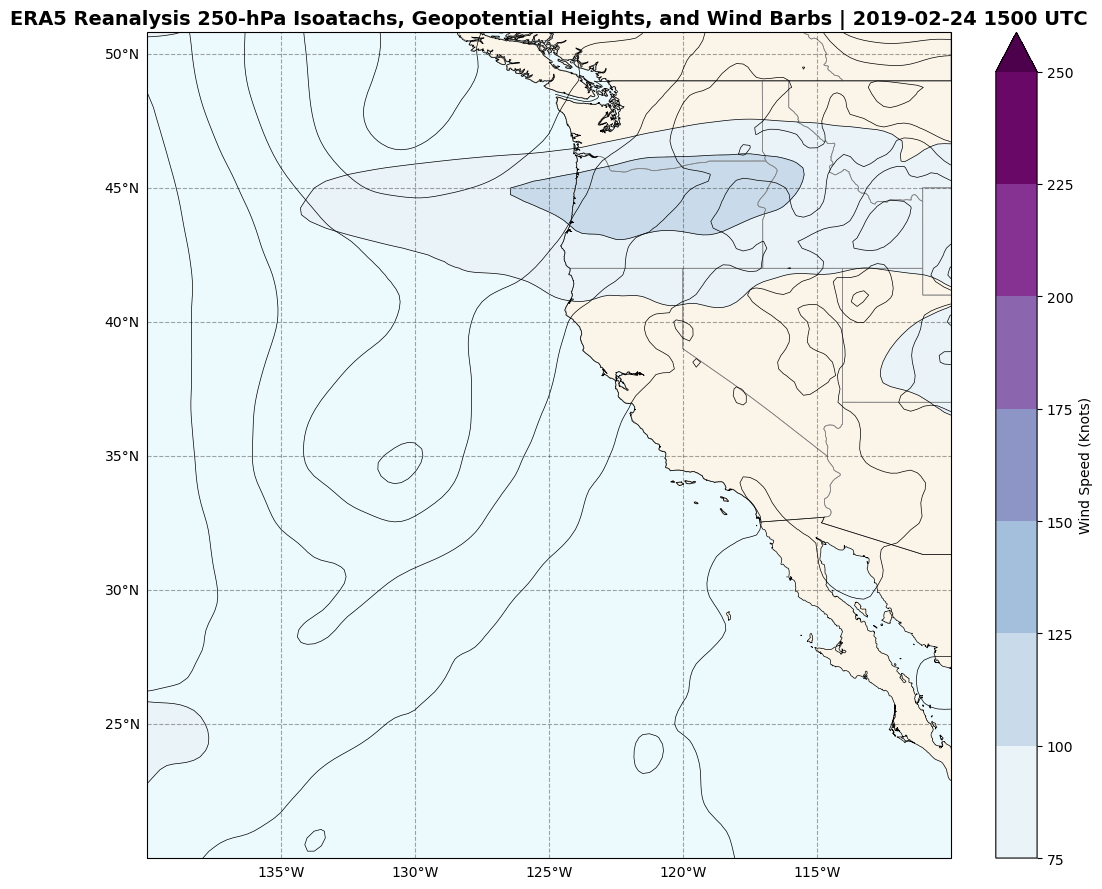

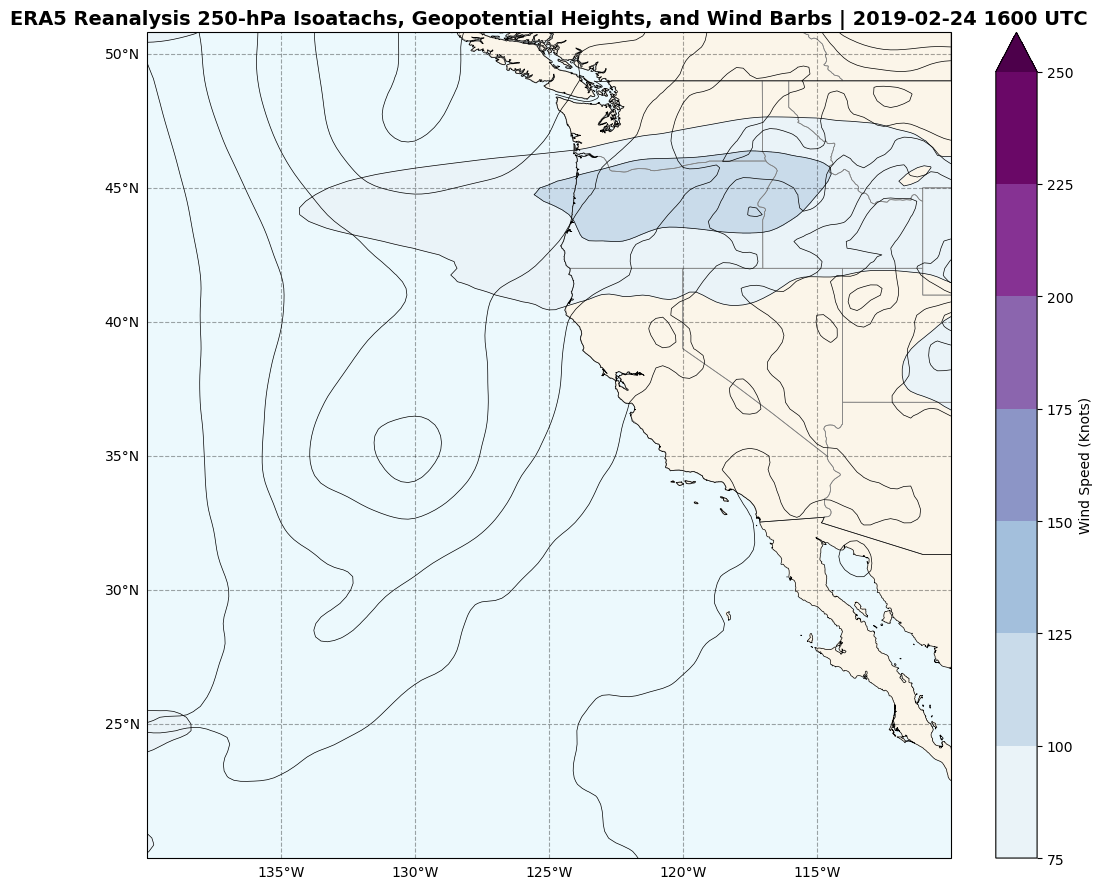

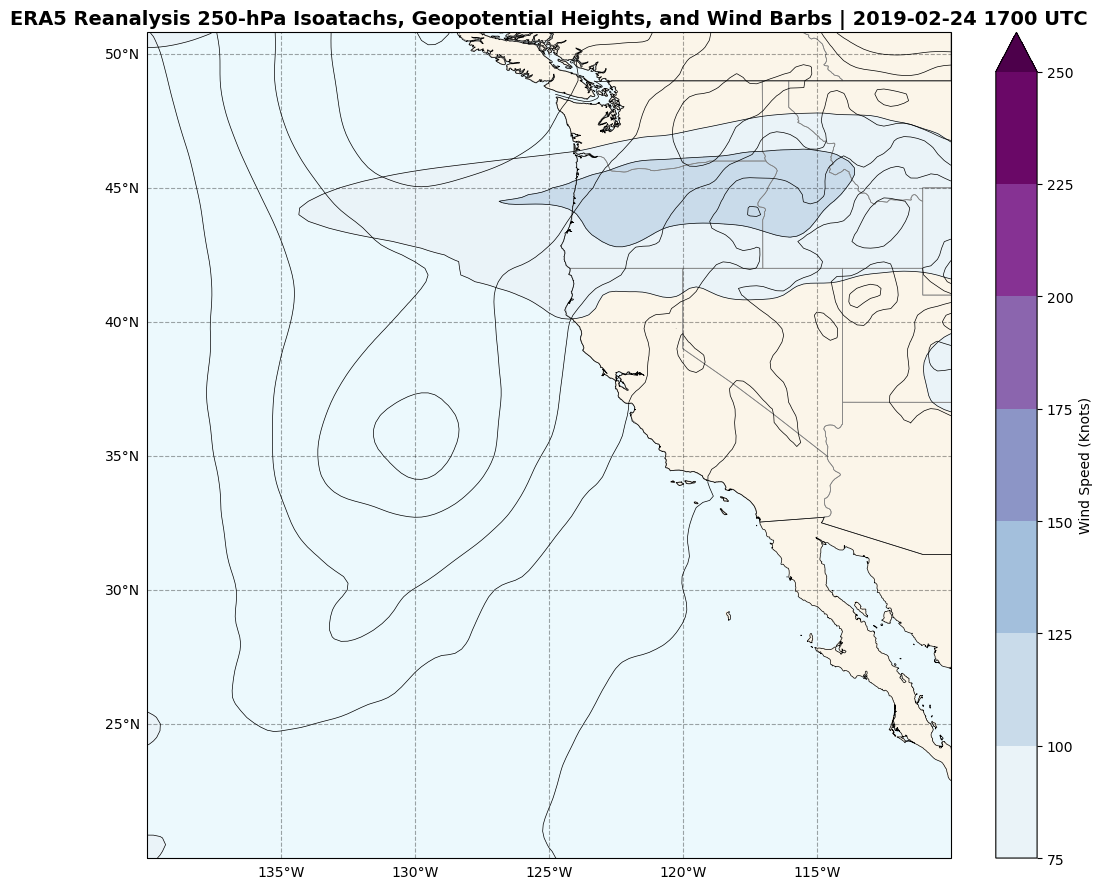

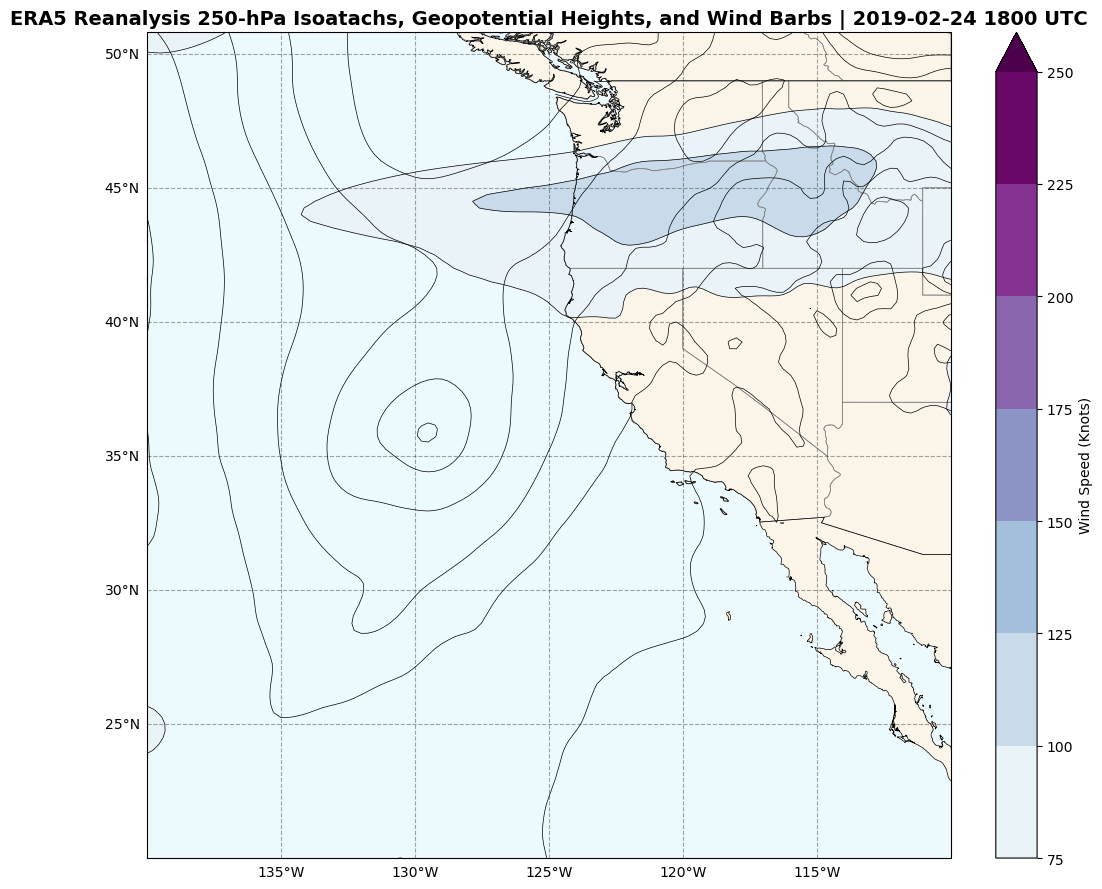

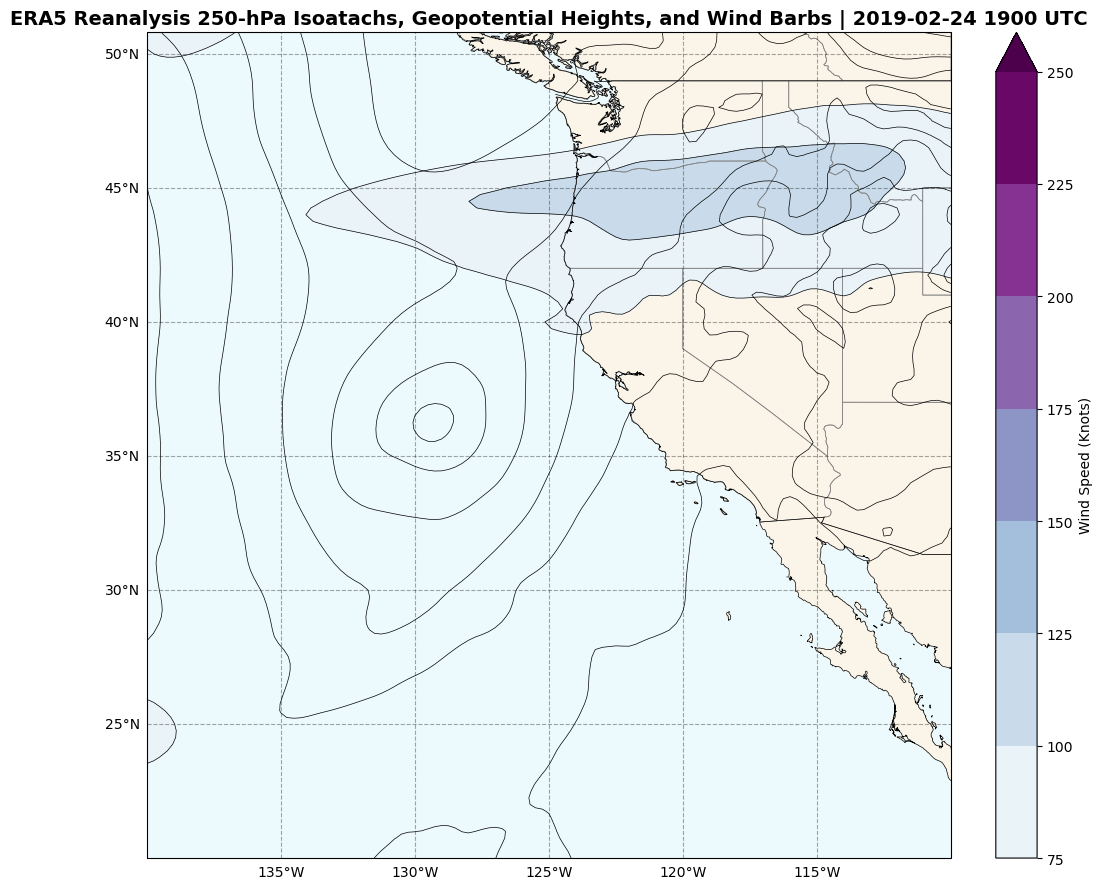

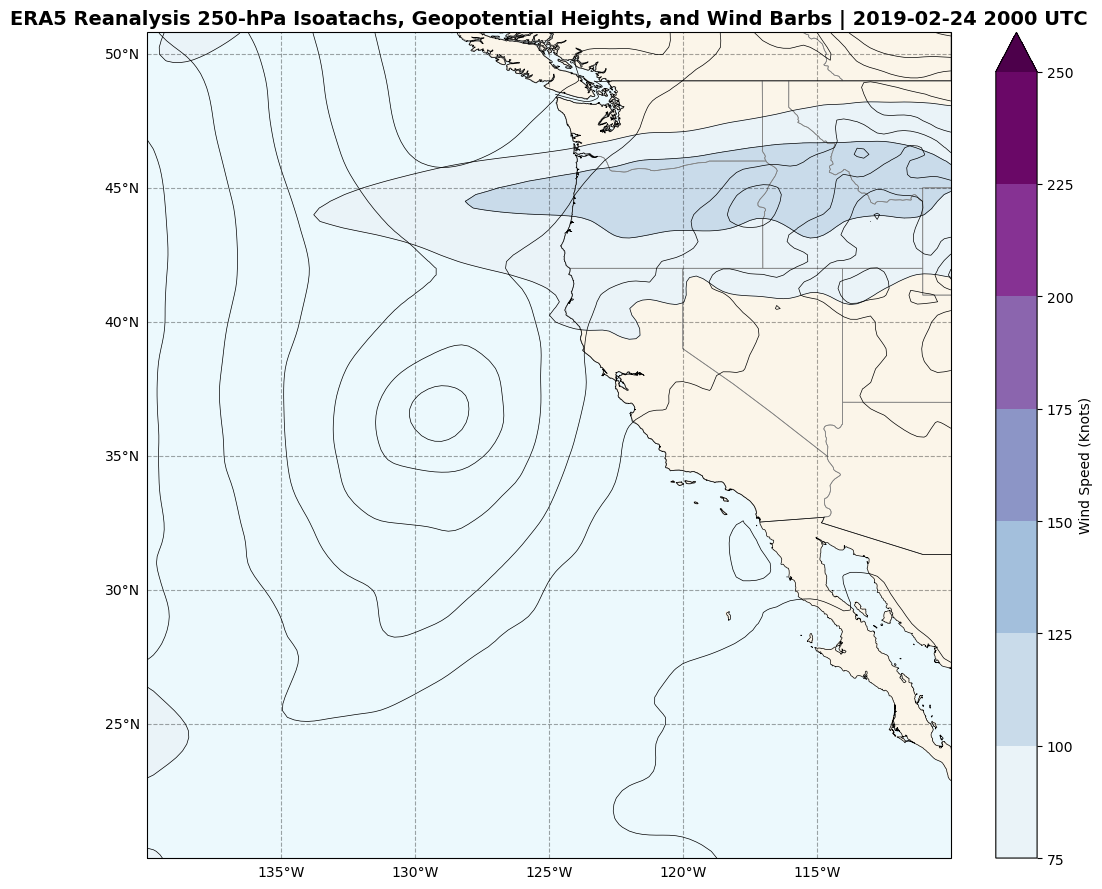

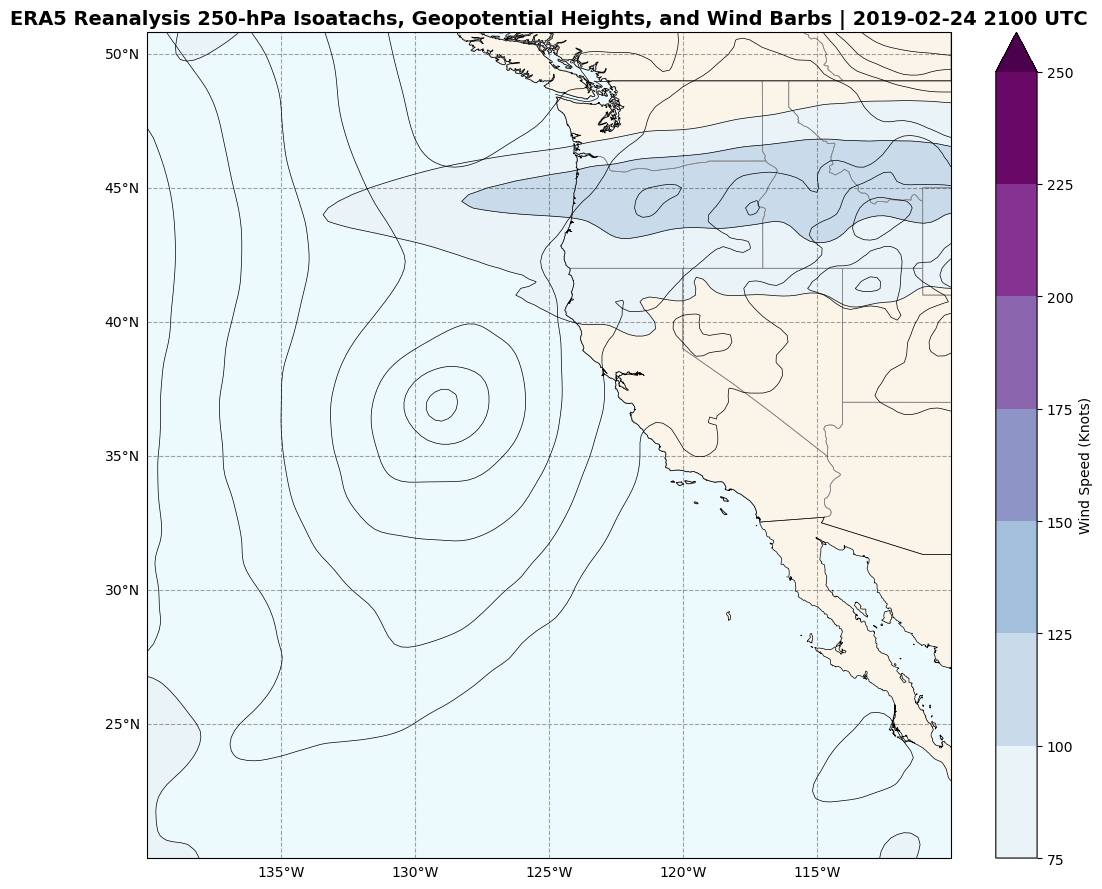

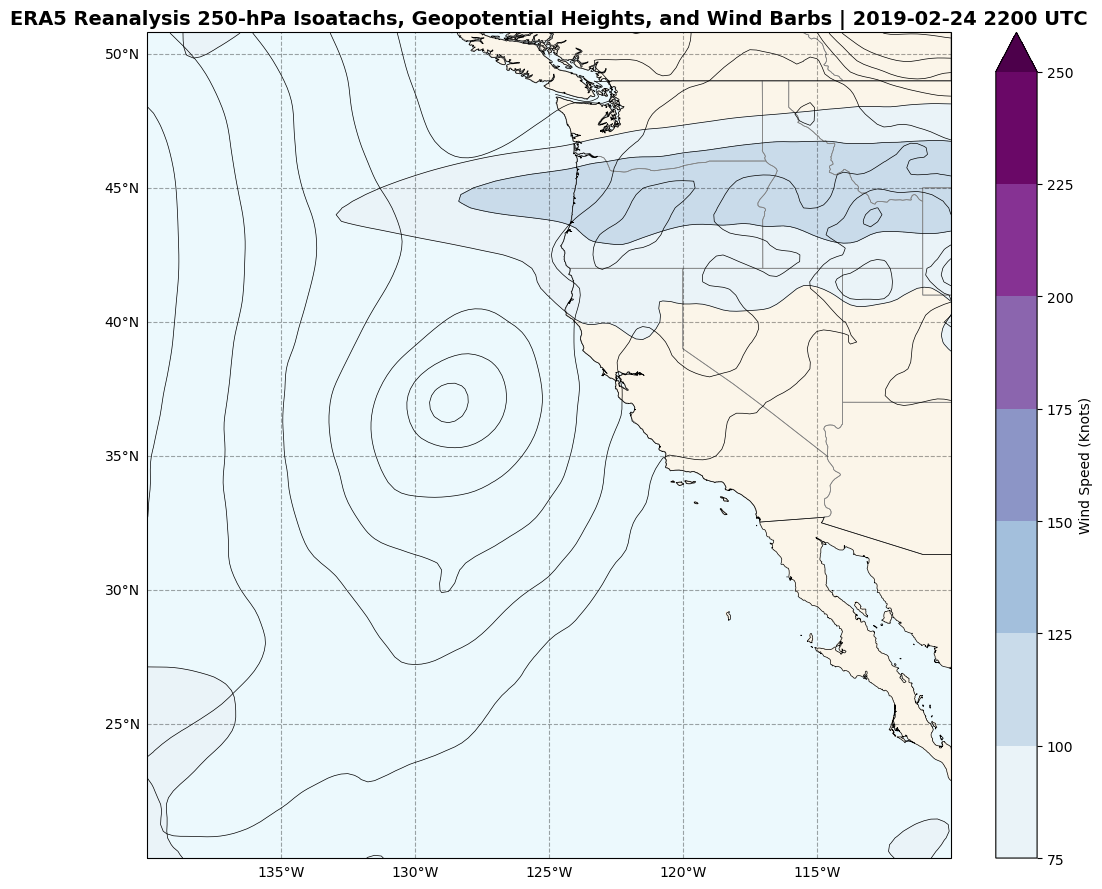

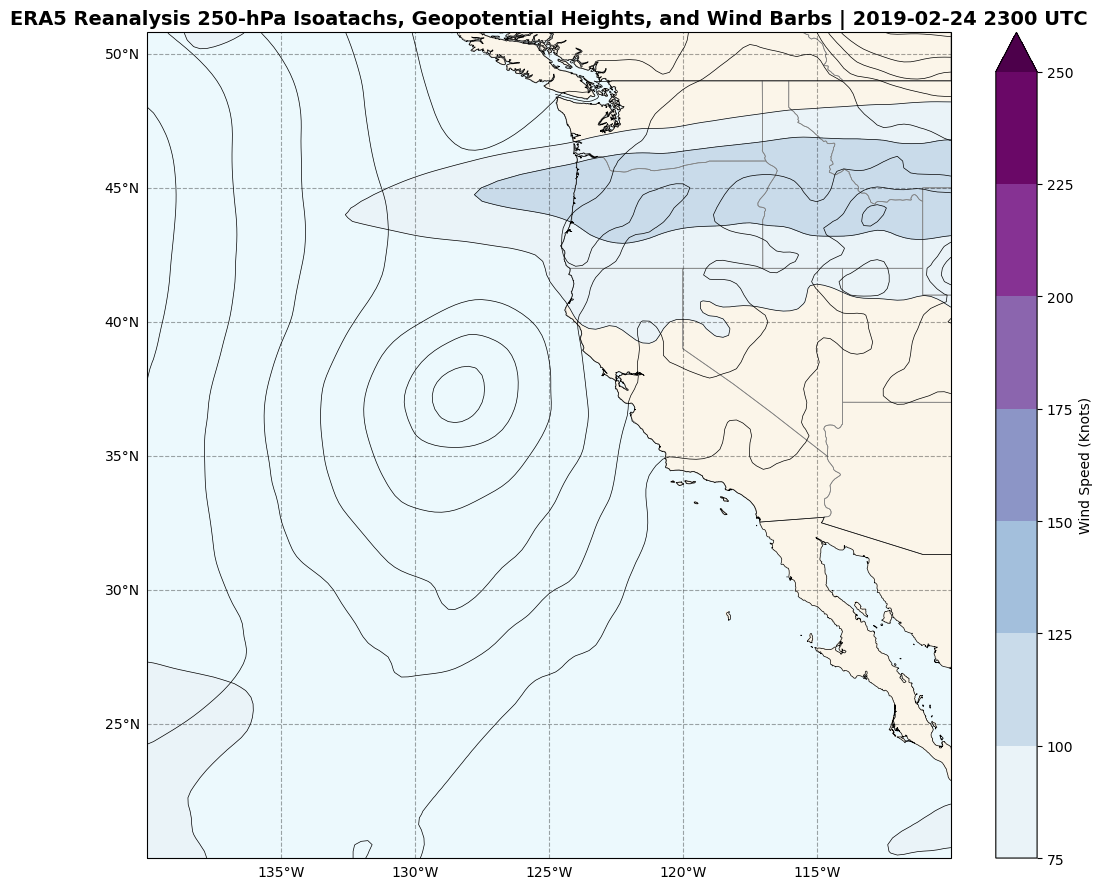

In [10]:
if __name__ == '__main__':

    directions = {'North': 51, 
                  'East': 250, 
                  'South': 20, 
                  'West': 220}
    g = 9.81 # units: m/s^2

    #plot_iwv(g, ds_pl, directions)
    #plot_ivt(g, ds_pl, directions)
    #plot_250_isotachs(ds_pl, directions)
    #plot_500_vorticity(ds_pl, directions)
    #plot_500_isotachs(ds_pl, directions)
    plot_250_isotachs_mslp(ds_pl, ds_sfc, directions)